14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing



📊 Prophet Forecast Performance on Test Set:
MSE: 32013737.33
RMSE: 5658.07
MAE: 4383.64
MAPE: 23.27%
R²: -7.8475
RRMSE: 0.2802
NRMSE: 0.6336


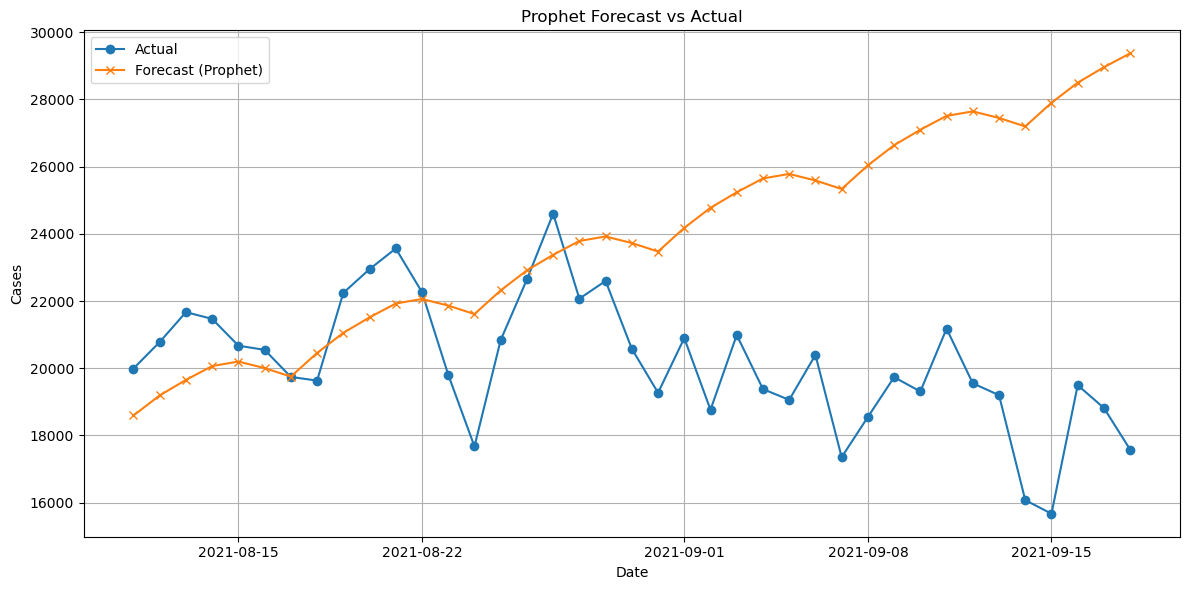

In [1]:
# === Import Libraries ===
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# === Load Data ===
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")  # update your path if needed

# Rename columns for Prophet
df = df.rename(columns={'Date': 'ds', 'New COVID-19 Cases': 'y'})

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Keep only necessary columns
df = df[['ds', 'y']].dropna()


# === Split Data into Train/Test ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train = df[df['ds'] <= train_end]
test = df[(df['ds'] >= test_start) & (df['ds'] <= test_end)]

# === Fit Prophet Model ===
model = Prophet()
model.fit(train)

# === Make Future DataFrame ===
future = model.make_future_dataframe(periods=len(test), freq='D')

# === Forecast ===
forecast = model.predict(future)

# === Extract Forecasted Values ===
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_start:test_end]
actual_test = test.set_index('ds')

# === Evaluation Metrics ===
y_true = actual_test['y']
y_pred = forecast_test['yhat']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)
rrmse = rmse / np.mean(y_true)
nrmse = rmse / (max(y_true) - min(y_true))

print(f"\n📊 Prophet Forecast Performance on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Plot Forecast vs Actual ===
plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label='Actual', marker='o')
plt.plot(y_pred.index, y_pred, label='Forecast (Prophet)', marker='x')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# === Actual vs Forecasted Values (12–18 Sept 2021) ===
comparison = pd.DataFrame({
    'Date': actual_test.loc['2021-09-12':'2021-09-18'].index,
    'Actual': actual_test.loc['2021-09-12':'2021-09-18']['y'].values,
    'Forecast': forecast_test.loc['2021-09-12':'2021-09-18']['yhat'].values
})

print("\n📌 Actual vs Forecasted (12–18 Sept 2021):")
print(comparison)



📌 Actual vs Forecasted (12–18 Sept 2021):
        Date  Actual      Forecast
0 2021-09-12   19550  27644.321039
1 2021-09-13   19198  27448.950766
2 2021-09-14   16073  27196.012396
3 2021-09-15   15669  27900.527990
4 2021-09-16   19495  28498.402592
5 2021-09-17   18815  28959.574000
6 2021-09-18   17577  29371.834968



📊 XGBoost Forecast Evaluation on Test Set:
MSE: 4351599.92
RMSE: 2086.05
MAE: 1647.30
MAPE: 8.01%
R²: -0.2026
RRMSE: 0.1033
NRMSE: 0.2336


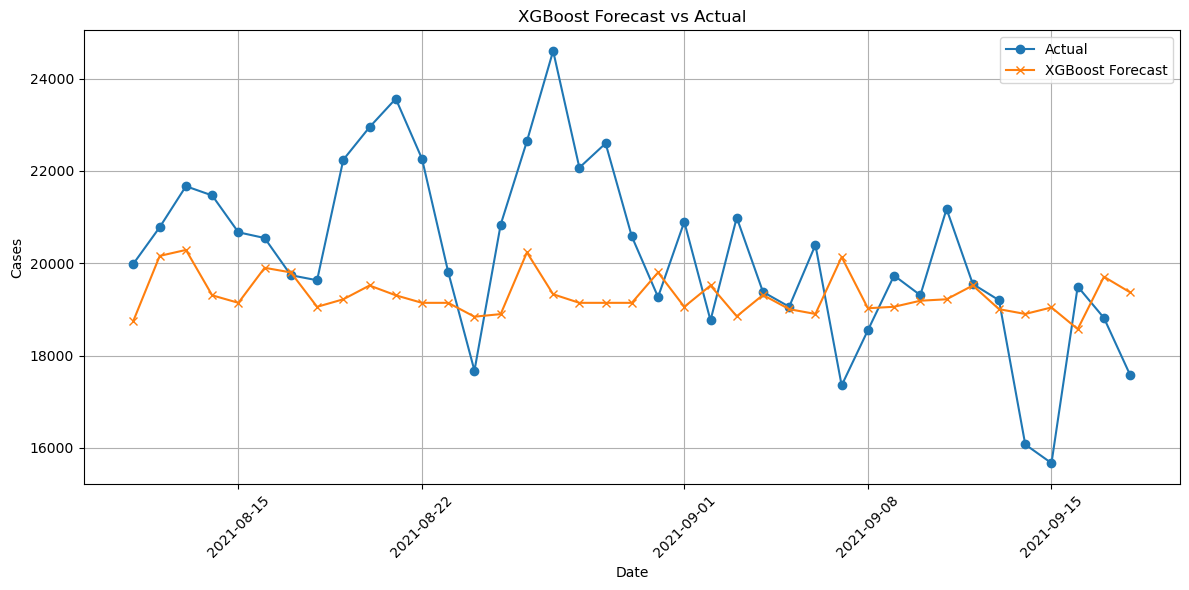


📌 XGBoost Forecast (12/09/2021 - 18/09/2021):
         Date  Actual      Forecast        Error     %Error
32 2021-09-12   19550  19517.193359    32.806641   0.167809
33 2021-09-13   19198  19004.488281   193.511719   1.007979
34 2021-09-14   16073  18900.464844 -2827.464844 -17.591395
35 2021-09-15   15669  19041.636719 -3372.636719 -21.524263
36 2021-09-16   19495  18572.488281   922.511719   4.732043
37 2021-09-17   18815  19706.570312  -891.570312  -4.738614
38 2021-09-18   17577  19368.035156 -1791.035156 -10.189652


In [5]:
# === Import Libraries ===
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")  # Update file path
data = data.rename(columns={'New COVID-19 Cases': 'y'})  # Rename target column
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date is datetime
data = data.sort_values('Date').reset_index(drop=True)

# === Create lag features ===
def create_lag_features(df, lag_days):
    for lag in lag_days:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    return df

lag_days = [1, 2, 3, 7, 14]
data = create_lag_features(data, lag_days)
data = data.dropna()

# === Train-test split ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train = data[(data['Date'] <= train_end)]
test = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]

feature_cols = [f'lag_{lag}' for lag in lag_days]
X_train = train[feature_cols]
y_train = train['y']
X_test = test[feature_cols]
y_test = test['y']

# === Fit XGBoost Model ===
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

# === Make predictions ===
y_pred = xgb.predict(X_test)

# === Evaluation metrics ===
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
rrmse = rmse / y_test.mean()
nrmse = rmse / (y_test.max() - y_test.min())

print("\n📊 XGBoost Forecast Evaluation on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Plot actual vs predicted ===
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test.values, label='Actual', marker='o')
plt.plot(test['Date'], y_pred, label='XGBoost Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('XGBoost Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Extract Actual vs Forecast for 12/09/2021 to 18/09/2021 ===
comparison_xgb = pd.DataFrame({
    'Date': test['Date'].values,
    'Actual': y_test.values,
    'Forecast': y_pred
})

comparison_xgb = comparison_xgb[(comparison_xgb['Date'] >= '2021-09-12') &
                                (comparison_xgb['Date'] <= '2021-09-18')]

# Add error metrics for each day
comparison_xgb['Error'] = comparison_xgb['Actual'] - comparison_xgb['Forecast']
comparison_xgb['%Error'] = (comparison_xgb['Error'] / comparison_xgb['Actual']) * 100

print("\n📌 XGBoost Forecast (12/09/2021 - 18/09/2021):")
print(comparison_xgb)




📊 SVR Forecast Evaluation on Test Set:
MSE: 282972174.54
RMSE: 16821.78
MAE: 16715.97
MAPE: 82.64%
R²: -77.2034
RRMSE: 0.8330
NRMSE: 1.8837

📅 Actual vs Forecast (12–18 Sept 2021):
          Date  Actual  Forecast
244 2021-09-12   19550      3396
245 2021-09-13   19198      3396
246 2021-09-14   16073      3396
247 2021-09-15   15669      3396
248 2021-09-16   19495      3396
249 2021-09-17   18815      3396
250 2021-09-18   17577      3396


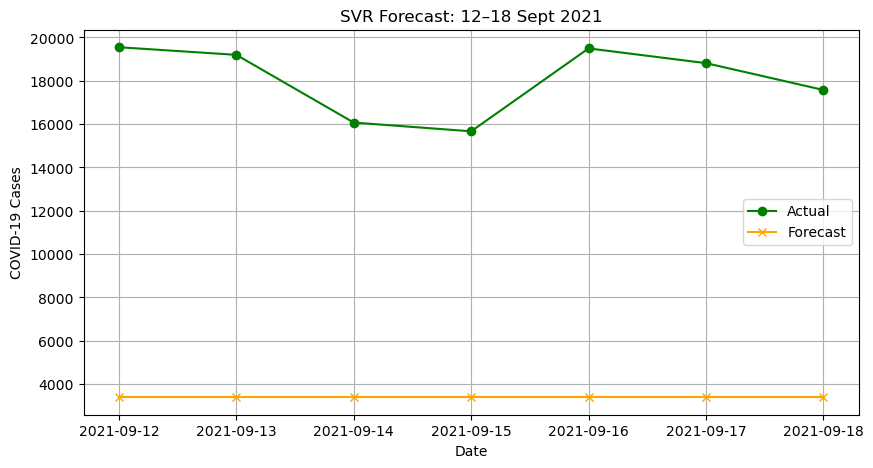

In [7]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===

data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")  # Update file path
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Filter dataset between Jan 4, 2021, and Sep 18, 2021
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Keep target series for comparison
target_series = data_filtered[['Date', 'New COVID-19 Cases']].copy()

# === Step 2: Create lag features ===
for lag in range(1, 8):
    data_filtered[f"lag_{lag}"] = data_filtered["New COVID-19 Cases"].shift(lag)

data_filtered = data_filtered.dropna().reset_index(drop=True)

# === Step 3: Split into train/val/test ===
train_set = data_filtered[(data_filtered['Date'] >= '2021-01-04') & (data_filtered['Date'] <= '2021-07-02')]
val_set   = data_filtered[(data_filtered['Date'] >= '2021-07-03') & (data_filtered['Date'] <= '2021-08-10')]
test_set  = data_filtered[(data_filtered['Date'] >= '2021-08-11') & (data_filtered['Date'] <= '2021-09-18')]

# Features and target
X_train, y_train = train_set.drop(columns=['Date','New COVID-19 Cases']).values, train_set['New COVID-19 Cases'].values
X_val,   y_val   = val_set.drop(columns=['Date','New COVID-19 Cases']).values,   val_set['New COVID-19 Cases'].values
X_test,  y_test  = test_set.drop(columns=['Date','New COVID-19 Cases']).values,  test_set['New COVID-19 Cases'].values

# Scale features only
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# === Step 4: Train SVR ===
model = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
model.fit(X_train, y_train)

# === Step 5: Predictions ===
val_pred  = model.predict(X_val)
test_pred = model.predict(X_test)

# === Step 6: Evaluate overall test ===
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_pred)
mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
r2 = r2_score(y_test, test_pred)
rrmse = rmse / y_test.mean()
nrmse = rmse / (y_test.max() - y_test.min())

print("\n📊 SVR Forecast Evaluation on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Step 7: Focus only on 12/09/21 - 18/09/21 ===
mask = (test_set['Date'] >= '2021-09-12') & (test_set['Date'] <= '2021-09-18')
subset_dates = test_set.loc[mask, 'Date']
subset_actual = y_test[mask]
subset_pred   = test_pred[mask]

# Table of actual vs predicted
forecast_table = pd.DataFrame({
    "Date": subset_dates,
    "Actual": subset_actual,
    "Forecast": subset_pred.round(0).astype(int)
})
print("\n📅 Actual vs Forecast (12–18 Sept 2021):")
print(forecast_table)

# === Step 8: Plot ===
plt.figure(figsize=(10,5))
plt.plot(subset_dates, subset_actual, marker="o", label="Actual", color="green")
plt.plot(subset_dates, subset_pred, marker="x", label="Forecast", color="orange")
plt.legend()
plt.title("SVR Forecast: 12–18 Sept 2021")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0199 - val_loss: 0.0954
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0852
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032 - val_loss: 0.0598
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0015 - val_loss: 0.0209
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013 - val_loss: 0.0124
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.3532e-04 - val_loss: 0.0045
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.9802e-04 - val_loss: 0.0058
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.6950e-04 - val_loss: 0.0063
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.2448e-04 - val_loss: 0.0061
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.5497e-04 - val_loss: 0.0049
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2

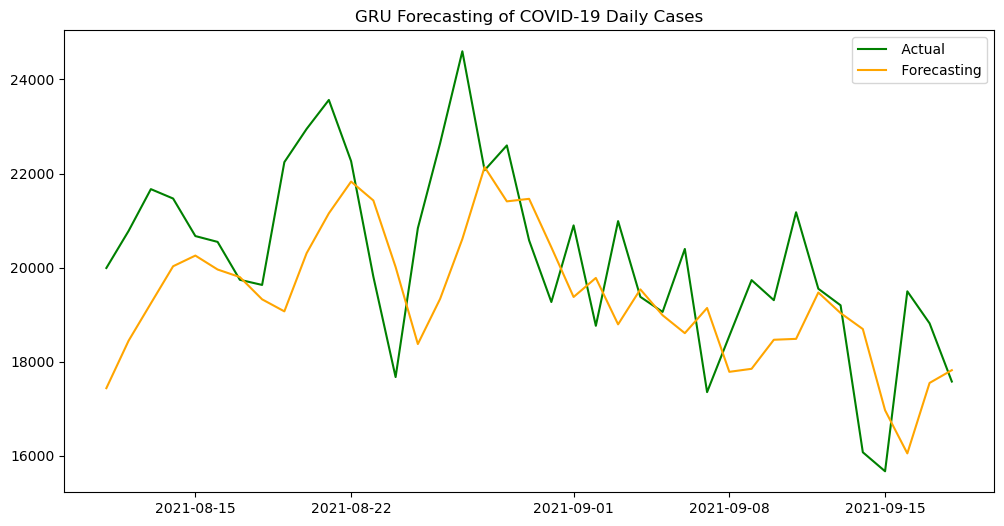

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# === Step 1: Load and preprocess data ===
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Filter dataset between Jan 4, 2021, and Sep 18, 2021
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Keep only target series
cases = data_filtered[['Date', 'New COVID-19 Cases']].copy()

# Normalize target
scaler = MinMaxScaler()
cases['scaled_cases'] = scaler.fit_transform(cases[['New COVID-19 Cases']])

# === Step 2: Create supervised sequences ===
def create_sequences(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 7  # past 7 days to predict next day
X, y = create_sequences(cases['scaled_cases'].values, window_size)

# Align with dates
dates = cases['Date'][window_size:].reset_index(drop=True)

# === Step 3: Train/val/test split ===
train_mask = (dates >= '2021-01-04') & (dates <= '2021-07-02')
val_mask   = (dates >= '2021-07-03') & (dates <= '2021-08-10')
test_mask  = (dates >= '2021-08-11') & (dates <= '2021-09-18')

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0],   X_val.shape[1],   1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1],  1))

# === Step 4: Build GRU model ===
model = Sequential()
model.add(GRU(64, activation='tanh', return_sequences=False, input_shape=(window_size,1)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict next day cases
model.compile(optimizer='adam', loss='mse')

# === Step 5: Train model ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

# === Step 6: Predictions ===
y_test_pred = model.predict(X_test)

# Inverse scale back to actual cases
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# === Step 6: Evaluate overall test ===
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_pred)
mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
r2 = r2_score(y_test, test_pred)
rrmse = rmse / y_test.mean()
nrmse = rmse / (y_test.max() - y_test.min())

print("\n📊 GRU Forecast Evaluation on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Step 8: Extract only 12–18 Sept 2021 forecast ===
mask_12_18 = (dates[test_mask] >= '2021-09-12') & (dates[test_mask] <= '2021-09-18')
forecast_df = pd.DataFrame({
    "Date": dates[test_mask][mask_12_18].values,
    "Actual": y_test_actual[mask_12_18].flatten(),
    "Predicted": y_test_pred[mask_12_18].flatten()
})

print("\n📌 GRU Forecast (12–18 Sept 2021):")
print(forecast_df)

# === Step 9: Plot ===
plt.figure(figsize=(12,6))
plt.plot(dates[test_mask], y_test_actual, label=" Actual", color="green")
plt.plot(dates[test_mask], y_test_pred, label=" Forecasting", color="orange")
plt.legend()
plt.title("GRU Forecasting of COVID-19 Daily Cases")
plt.show()



📌 GARCH Forecast (12/09/2021 - 18/09/2021):
            Actual      Forecast
2021-09-12   19550  21592.892368
2021-09-13   19198  22016.944344
2021-09-14   16073  22448.232915
2021-09-15   15669  22886.855825
2021-09-16   19495  23332.854319
2021-09-17   18815  23786.451275
2021-09-18   17577  24247.703170

📊 Evaluation Metrics:
MSE: 26971946.89
RMSE: 5193.45
MAE: 4847.85
MAPE: 27.85%
R²: -10.7690
RRMSE: 0.2877
NRMSE: 1.3382


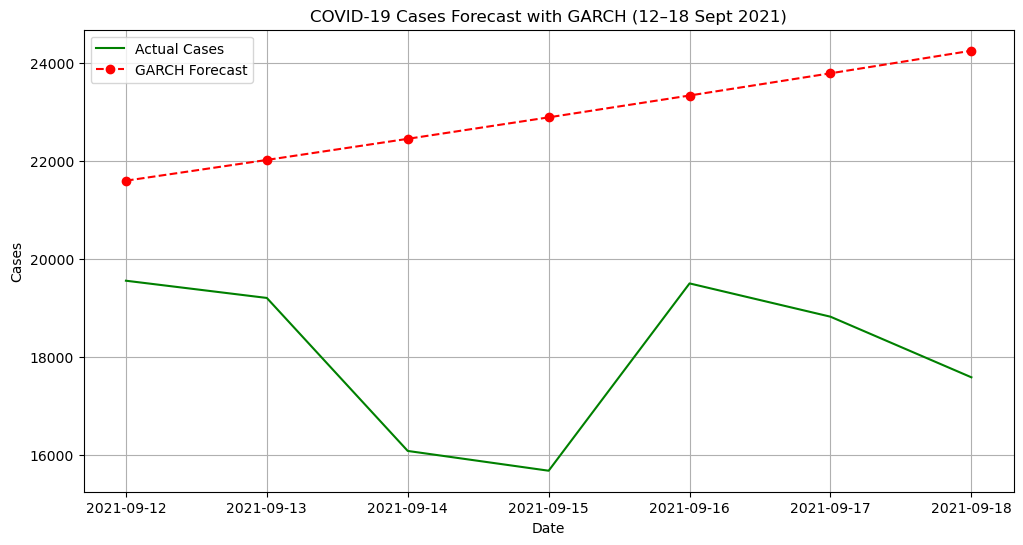

In [13]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Target series
series = df.set_index("Date")['New COVID-19 Cases']

# === Step 2: Returns for GARCH ===
returns = 100 * series.pct_change().dropna()

# === Step 3: Define forecast period (12–18 Sept 2021) ===
start_date = '2021-09-12'
end_date   = '2021-09-18'
forecast_dates = pd.date_range(start=start_date, end=end_date)

# Training data: all before forecast start
train_returns = returns.loc[:'2021-09-11']
history = list(train_returns.values)

rolling_forecast_garch = []

# === Step 4: Rolling 1-step-ahead forecasts ===
for date in forecast_dates:
    model = arch_model(history, vol="GARCH", p=1, q=1, dist="normal")
    model_fit = model.fit(disp="off")

    forecast = model_fit.forecast(horizon=1)
    next_return = forecast.mean.iloc[-1, 0]  # forecasted return (%)
    rolling_forecast_garch.append(next_return)

    # Update history with predicted return
    history.append(next_return)

# === Step 5: Convert returns → cases ===
last_actual = series.loc['2021-09-11']  # last observed before forecast
predicted_cases = [last_actual * (1 + rolling_forecast_garch[0]/100)]
for r in rolling_forecast_garch[1:]:
    predicted_cases.append(predicted_cases[-1] * (1 + r/100))

forecast_cases_garch = pd.Series(predicted_cases, index=forecast_dates)

# === Step 6: Actual vs Forecast ===
actual_cases = series.loc[start_date:end_date]
comparison = pd.DataFrame({
    "Actual": actual_cases,
    "Forecast": forecast_cases_garch
})

# === Step 7: Evaluation Metrics ===
mse = mean_squared_error(comparison["Actual"], comparison["Forecast"])
mae = mean_absolute_error(comparison["Actual"], comparison["Forecast"])
mape = np.mean(np.abs((comparison["Actual"] - comparison["Forecast"]) / comparison["Actual"])) * 100
rmse = np.sqrt(mse)
rrmse = rmse / np.mean(comparison["Actual"])
nrmse = rmse / (comparison["Actual"].max() - comparison["Actual"].min())
r2 = r2_score(comparison["Actual"], comparison["Forecast"])

print("\n📌 GARCH Forecast (12/09/2021 - 18/09/2021):")
print(comparison)
print("\n📊 Evaluation Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Step 8: Plot ===
plt.figure(figsize=(12,6))
plt.plot(series.loc['2021-09-12':'2021-09-18'], label="Actual Cases", color="green")
plt.plot(forecast_cases_garch, label="GARCH Forecast", color="red", linestyle="--", marker="o")
plt.title("COVID-19 Cases Forecast with GARCH (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fai

                               SARIMAX Results                                
Dep. Variable:     New COVID-19 Cases   No. Observations:                  219
Model:                 ARIMA(7, 4, 6)   Log Likelihood               -1732.275
Date:                Mon, 22 Sep 2025   AIC                           3492.551
Time:                        14:59:50   BIC                           3539.740
Sample:                    01-04-2021   HQIC                          3511.617
                         - 08-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8824      0.341     -5.524      0.000      -2.550      -1.214
ar.L2         -1.0699      0.734     -1.458      0.145      -2.508       0.368
ar.L3         -0.6145      0.566     -1.086      0.2

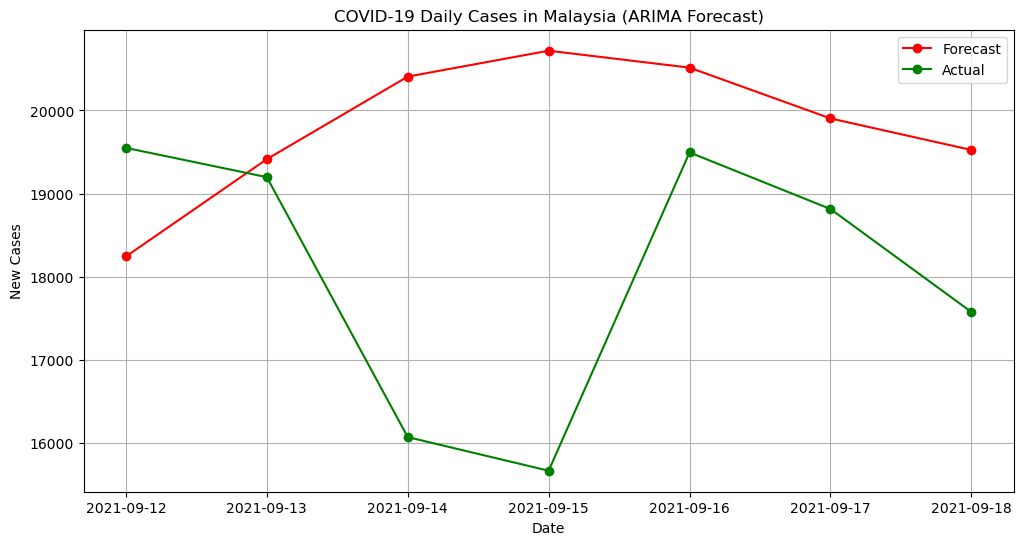

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Filter dataset between Jan 4, 2021, and Sep 18, 2021
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Keep original Date column separately
dates = data_filtered['Date']

# Normalize all columns except Date
scaler = MinMaxScaler()
features = data_filtered.drop(columns=['Date'])
normalized_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
normalized_features['Date'] = dates

# === Step 2: Split into train/val/test ===
train_set = normalized_features[(normalized_features['Date'] >= '2021-01-04') & (normalized_features['Date'] <= '2021-07-02')]
val_set = normalized_features[(normalized_features['Date'] >= '2021-07-03') & (normalized_features['Date'] <= '2021-08-10')]
test_set = normalized_features[(normalized_features['Date'] >= '2021-08-11') & (normalized_features['Date'] <= '2021-09-18')]

# Reset index for each
train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

# === Step 3: Time series model on actual cases ===
# We'll use unnormalized actual cases for ARIMA forecasting
covid_cases_ts = data_filtered.set_index('Date')['New COVID-19 Cases']  # Replace 'Cases' with your actual column name

# Train ARIMA model on training + validation set
arima_train_series = covid_cases_ts['2021-01-04':'2021-08-10']
arima_model = ARIMA(arima_train_series, order=(7,4,6))  # You can optimize (p,d,q) or use auto_arima
arima_model = arima_model.fit()

# Print the model summary
print(arima_model.summary())

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Step 4: Forecast and evaluate
test_data = covid_cases_ts['2021-08-11':'2021-09-18']
forecast = arima_model.forecast(steps=len(test_data))
forecast = pd.Series(forecast, index=test_data.index)

# Metrics
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_data) - np.min(test_data))
nrmse = rmse / np.mean(test_data)  # Normalized RMSE by mean
r2 = r2_score(test_data, forecast)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
# Assuming your model is called `arima_model`
forecast = arima_model.forecast(steps=7)  # 7 days forecast
forecast.index = pd.date_range(start='2021-09-12', periods=7, freq='D')
print(forecast)
# === Step 5: Forecast for 12/09/2021 - 18/09/2021 ===
forecast_range = arima_model.forecast(steps=7)
forecast_range.index = pd.date_range(start='2021-09-12', periods=7, freq='D')

# Actual values for the same period
actual_range = covid_cases_ts['2021-09-12':'2021-09-18']

# === Step 6: Plot ===
plt.figure(figsize=(12,6))

plt.plot(forecast_range.index, forecast_range, label="Forecast", color="red", marker="o")
plt.plot(actual_range.index, actual_range, label="Actual", color="green", marker="o")

plt.title("COVID-19 Daily Cases in Malaysia (ARIMA Forecast)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1026
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025  

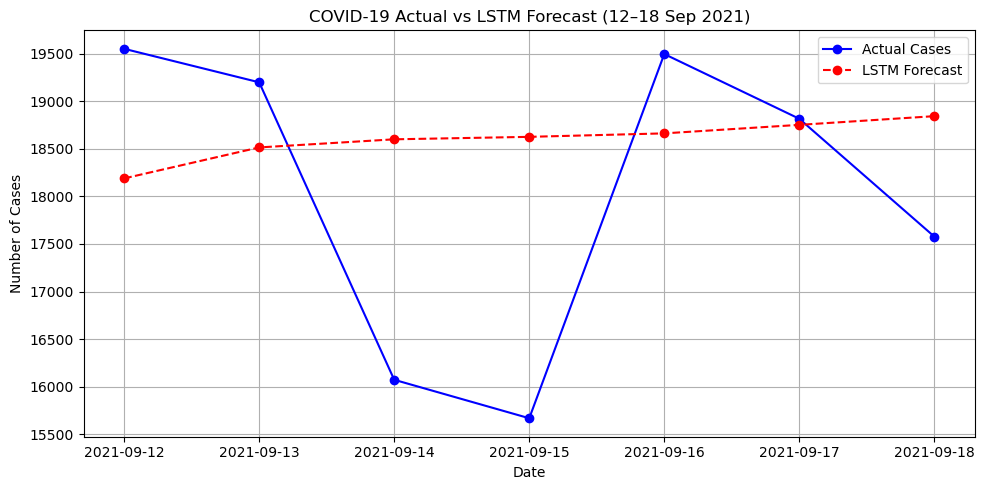

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

target_col = 'New COVID-19 Cases'
target_series = data[[target_col, 'Date']].copy()

# === Step 2: Train-test split (same as ARIMA example) ===
train_data = target_series[(target_series['Date'] <= '2021-08-10')]
test_data = target_series[(target_series['Date'] >= '2021-08-11') & (target_series['Date'] <= '2021-09-18')]

# === Step 3: Normalize data (only on train) ===
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[[target_col]])
test_scaled = scaler.transform(test_data[[target_col]])

# === Step 4: Create sequences for LSTM ===
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 10
x_train, y_train = create_sequences(train_scaled, seq_length)
x_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape to (samples, seq_length, features)
x_train = x_train.reshape((x_train.shape[0], seq_length, 1))
x_test = x_test.reshape((x_test.shape[0], seq_length, 1))

# === Step 5: Build and train LSTM model ===
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=200, batch_size=16, verbose=1)

# === Step 6: Predict on test set ===
y_pred = model.predict(x_test)

# Inverse scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# === Step 7: Evaluate LSTM model ===
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(y_test_rescaled) - np.min(y_test_rescaled))
nrmse = rmse / np.mean(y_test_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("\n📊 Final LSTM Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Step 8: Rolling Forecast for 12–18 Sep 2021 ===
forecast_horizon = pd.date_range(start='2021-09-12', end='2021-09-18')

last_sequence = test_scaled[-seq_length:]  # last window from test
forecast_scaled = []

for _ in range(len(forecast_horizon)):
    input_seq = last_sequence.reshape((1, seq_length, 1))
    next_scaled = model.predict(input_seq, verbose=0)[0][0]
    forecast_scaled.append([next_scaled])
    last_sequence = np.vstack((last_sequence[1:], [[next_scaled]]))

forecast_scaled = np.array(forecast_scaled)
forecast_rescaled = scaler.inverse_transform(forecast_scaled)

lstm_forecast_series = pd.Series(forecast_rescaled.flatten(), index=forecast_horizon)

print("\n📈 LSTM Rolling Forecast (12–18 Sep 2021):")
print(lstm_forecast_series)

# === Step 9: Plot Actual vs Forecast (12–18 Sep 2021 only) ===
plt.figure(figsize=(10,5))

# Actual observed cases in forecast horizon
actual_forecast_period = target_series.set_index("Date").loc["2021-09-12":"2021-09-18", target_col]

# Plot actual
plt.plot(actual_forecast_period.index, actual_forecast_period.values,
         label="Actual Cases", color="blue", marker="o")

# Plot forecast
plt.plot(lstm_forecast_series.index, lstm_forecast_series.values,
         label="LSTM Forecast", color="red", linestyle="--", marker="o")

plt.title("COVID-19 Actual vs LSTM Forecast (12–18 Sep 2021)")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Actual values (same across models)
actual = pd.Series(
    [19550, 19198, 16073, 15669, 19495, 18815, 17577],
    index=pd.date_range("2021-09-12", "2021-09-18"),
    name="Actual"
)

# Forecasts
prophet = [27644.321039, 27448.950766, 27196.012396, 27900.527990, 28498.402592, 28959.574000, 29371.834968]
xgboost = [19517.193359, 19004.488281, 18900.464844, 19041.636719, 18572.488281, 19706.570312, 19368.035156]
svr     = [3396, 3396, 3396, 3396, 3396, 3396, 3396]
gru     = [19469.722656, 19032.810547, 18693.052734, 16966.289062, 16049.021484, 17547.144531, 17818.824219]
garch   = [21592.892368, 22016.944344, 22448.232915, 22886.855825, 23332.854319, 23786.451275, 24247.703170]
arima   = [18244.780849, 19414.104306, 20406.755281, 20717.740675, 20514.247754, 19903.905194, 19524.769092]
lstm    = [18188.546875, 18514.035156, 18599.216797, 18625.162109, 18661.666016, 18751.134766, 18842.439453]

df = pd.DataFrame({
    "Actual": actual.values,
    "Prophet": prophet,
    "XGBoost": xgboost,
    "SVR": svr,
    "GRU": gru,
    "GARCH": garch,
    "ARIMA": arima,
    "LSTM": lstm
}, index=actual.index)

print(df)


            Actual       Prophet       XGBoost   SVR           GRU  \
2021-09-12   19550  27644.321039  19517.193359  3396  19469.722656   
2021-09-13   19198  27448.950766  19004.488281  3396  19032.810547   
2021-09-14   16073  27196.012396  18900.464844  3396  18693.052734   
2021-09-15   15669  27900.527990  19041.636719  3396  16966.289062   
2021-09-16   19495  28498.402592  18572.488281  3396  16049.021484   
2021-09-17   18815  28959.574000  19706.570312  3396  17547.144531   
2021-09-18   17577  29371.834968  19368.035156  3396  17818.824219   

                   GARCH         ARIMA          LSTM  
2021-09-12  21592.892368  18244.780849  18188.546875  
2021-09-13  22016.944344  19414.104306  18514.035156  
2021-09-14  22448.232915  20406.755281  18599.216797  
2021-09-15  22886.855825  20717.740675  18625.162109  
2021-09-16  23332.854319  20514.247754  18661.666016  
2021-09-17  23786.451275  19903.905194  18751.134766  
2021-09-18  24247.703170  19524.769092  18842.439453  

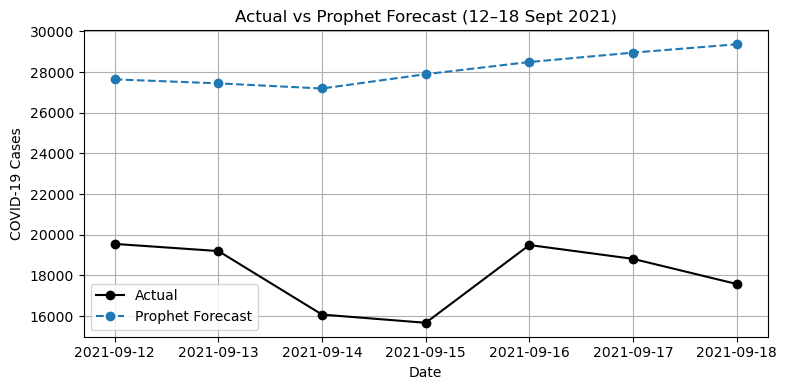

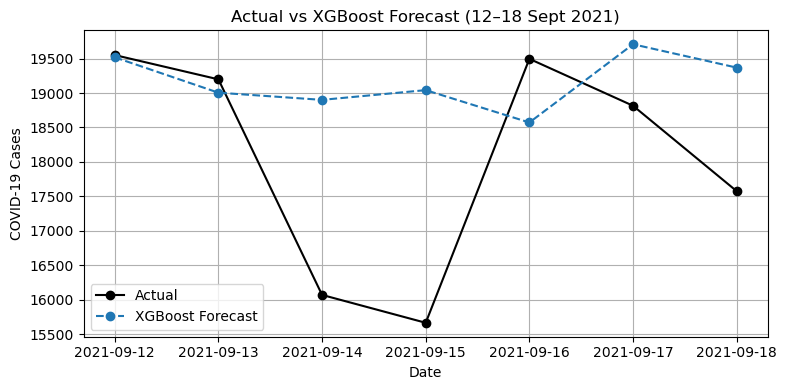

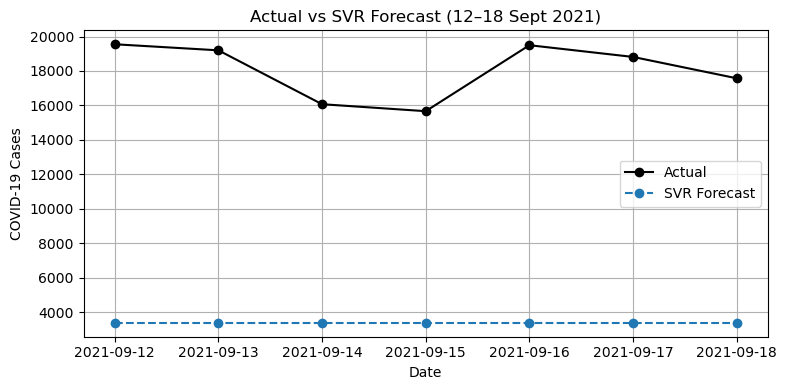

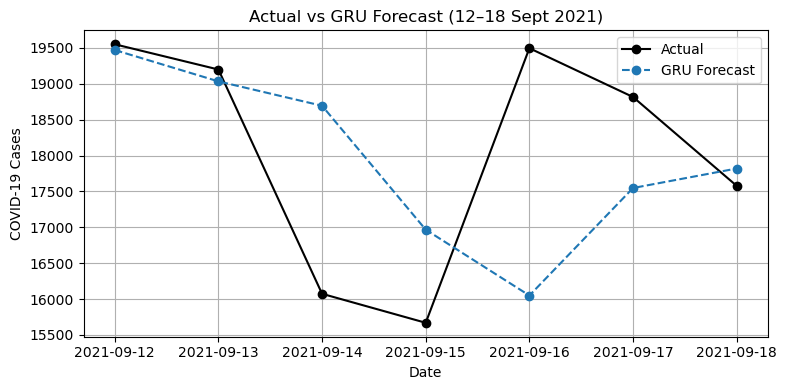

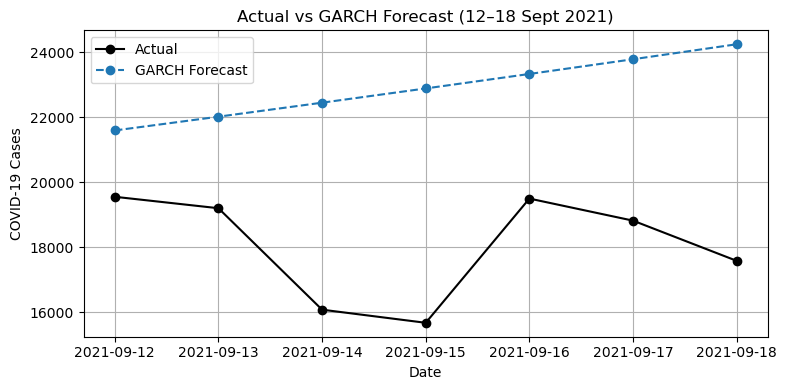

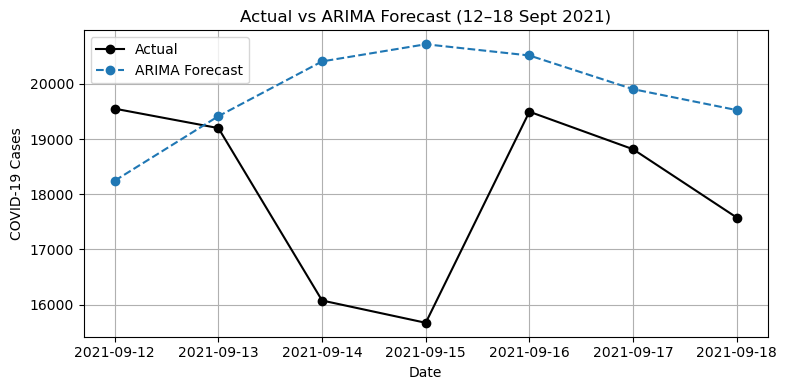

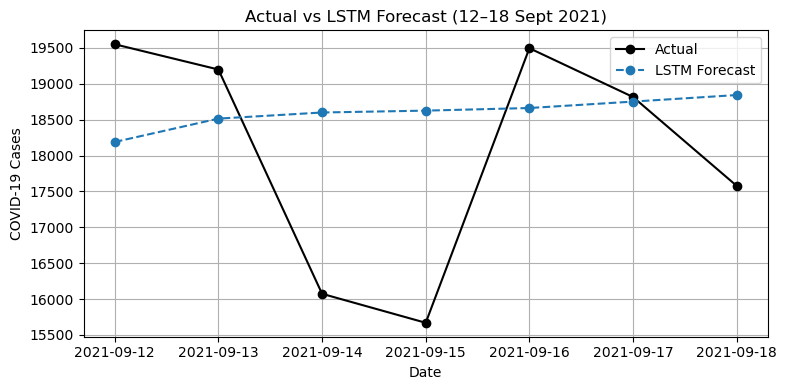

In [23]:
for model in df.columns[1:]:
    plt.figure(figsize=(8,4))
    plt.plot(df.index, df["Actual"], marker="o", label="Actual", color="black")
    plt.plot(df.index, df[model], marker="o", linestyle="--", label=f"{model} Forecast")
    plt.title(f"Actual vs {model} Forecast (12–18 Sept 2021)")
    plt.xlabel("Date")
    plt.ylabel("COVID-19 Cases")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


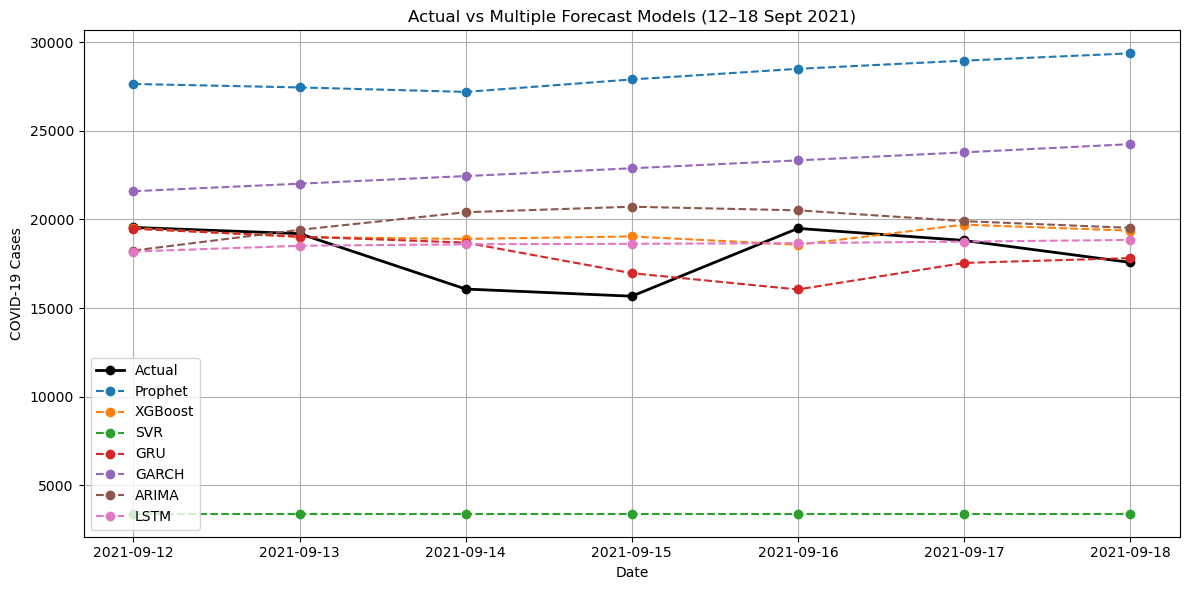

In [33]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Actual"], marker="o", color="black", linewidth=2, label="Actual")

# Forecast models
for model in df.columns[1:]:
    plt.plot(df.index, df[model], marker="o", linestyle="--", label=model)

plt.title("Actual vs Multiple Forecast Models (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


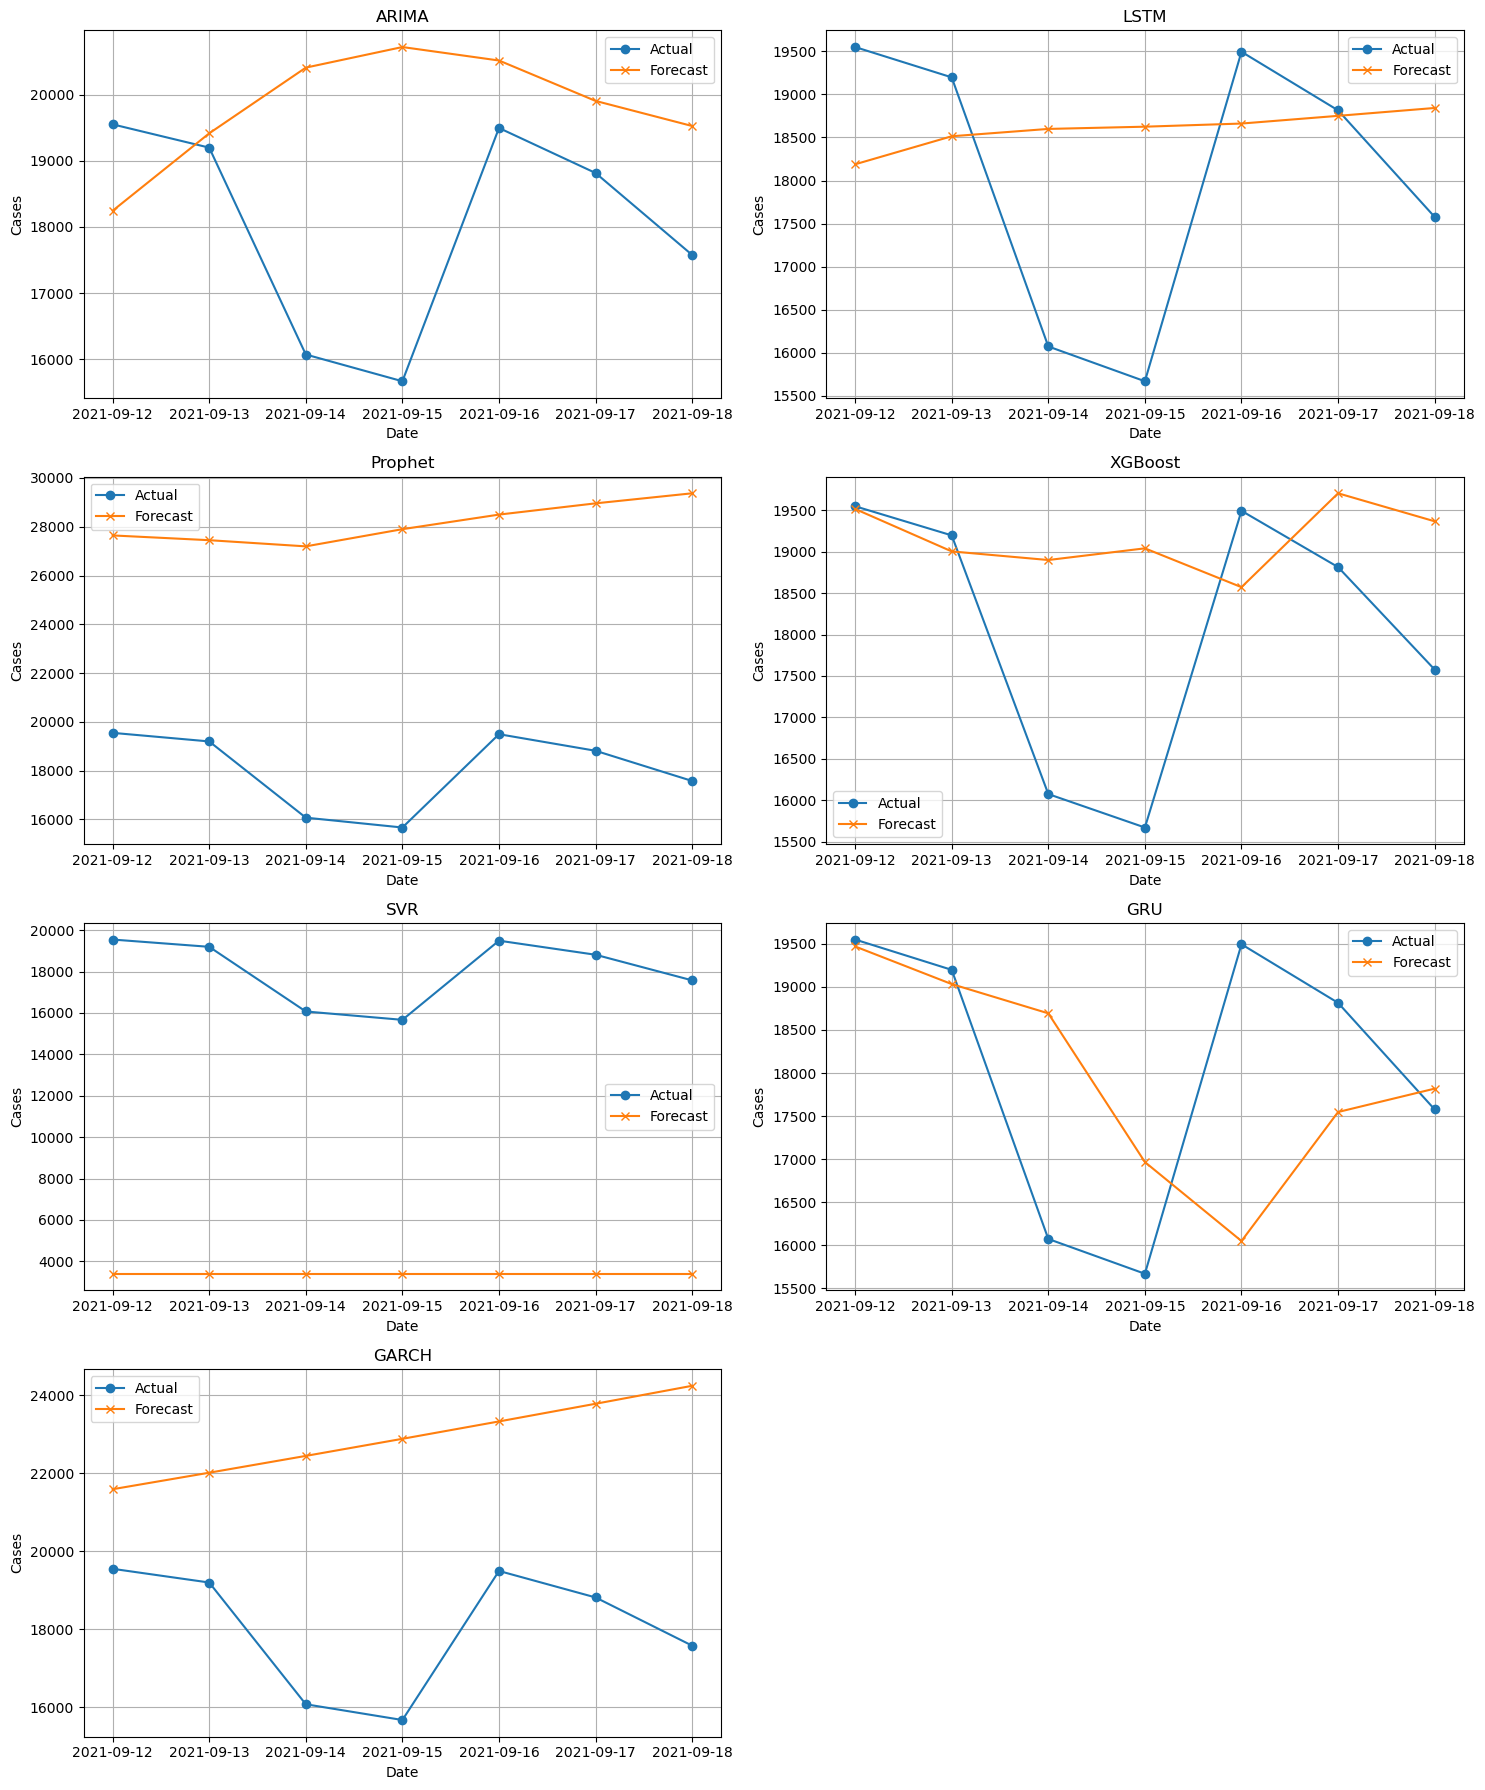

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Prophet results
prophet_df = pd.DataFrame({
    "Date": pd.to_datetime([
        "2021-09-12","2021-09-13","2021-09-14","2021-09-15","2021-09-16","2021-09-17","2021-09-18"
    ]),
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [27644.321039,27448.950766,27196.012396,27900.527990,28498.402592,28959.574000,29371.834968]
})

# XGBoost results
xgb_df = pd.DataFrame({
    "Date": prophet_df["Date"],
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [19517.193359,19004.488281,18900.464844,19041.636719,18572.488281,19706.570312,19368.035156]
})

# SVR results
svr_df = pd.DataFrame({
    "Date": prophet_df["Date"],
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [3396,3396,3396,3396,3396,3396,3396]
})

# GRU results
gru_df = pd.DataFrame({
    "Date": prophet_df["Date"],
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [19469.722656,19032.810547,18693.052734,16966.289062,16049.021484,17547.144531,17818.824219]
})

# GARCH results
garch_df = pd.DataFrame({
    "Date": prophet_df["Date"],
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [21592.892368,22016.944344,22448.232915,22886.855825,23332.854319,23786.451275,24247.703170]
})

# ARIMA results
arima_df = pd.DataFrame({
    "Date": prophet_df["Date"],
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [18244.780849,19414.104306,20406.755281,20717.740675,20514.247754,19903.905194,19524.769092]
})

# LSTM results
lstm_df = pd.DataFrame({
    "Date": prophet_df["Date"],
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [18188.546875,18514.035156,18599.216797,18625.162109,18661.666016,18751.134766,18842.439453]
})

# Dictionary of models
models = {
    "ARIMA": arima_df,
    "LSTM": lstm_df,
    "Prophet": prophet_df,
    "XGBoost": xgb_df,
    "SVR": svr_df,
    "GRU": gru_df,
    "GARCH": garch_df,
    
}

# Plot all models in subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 18))
axes = axes.flatten()

for i, (model_name, df) in enumerate(models.items()):
    ax = axes[i]
    ax.plot(df["Date"], df["Actual"], label="Actual", marker="o")
    ax.plot(df["Date"], df["Forecast"], label="Forecast", marker="x")
    ax.set_title(model_name, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cases")
    ax.legend()
    ax.grid(True)

# Remove empty subplot
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


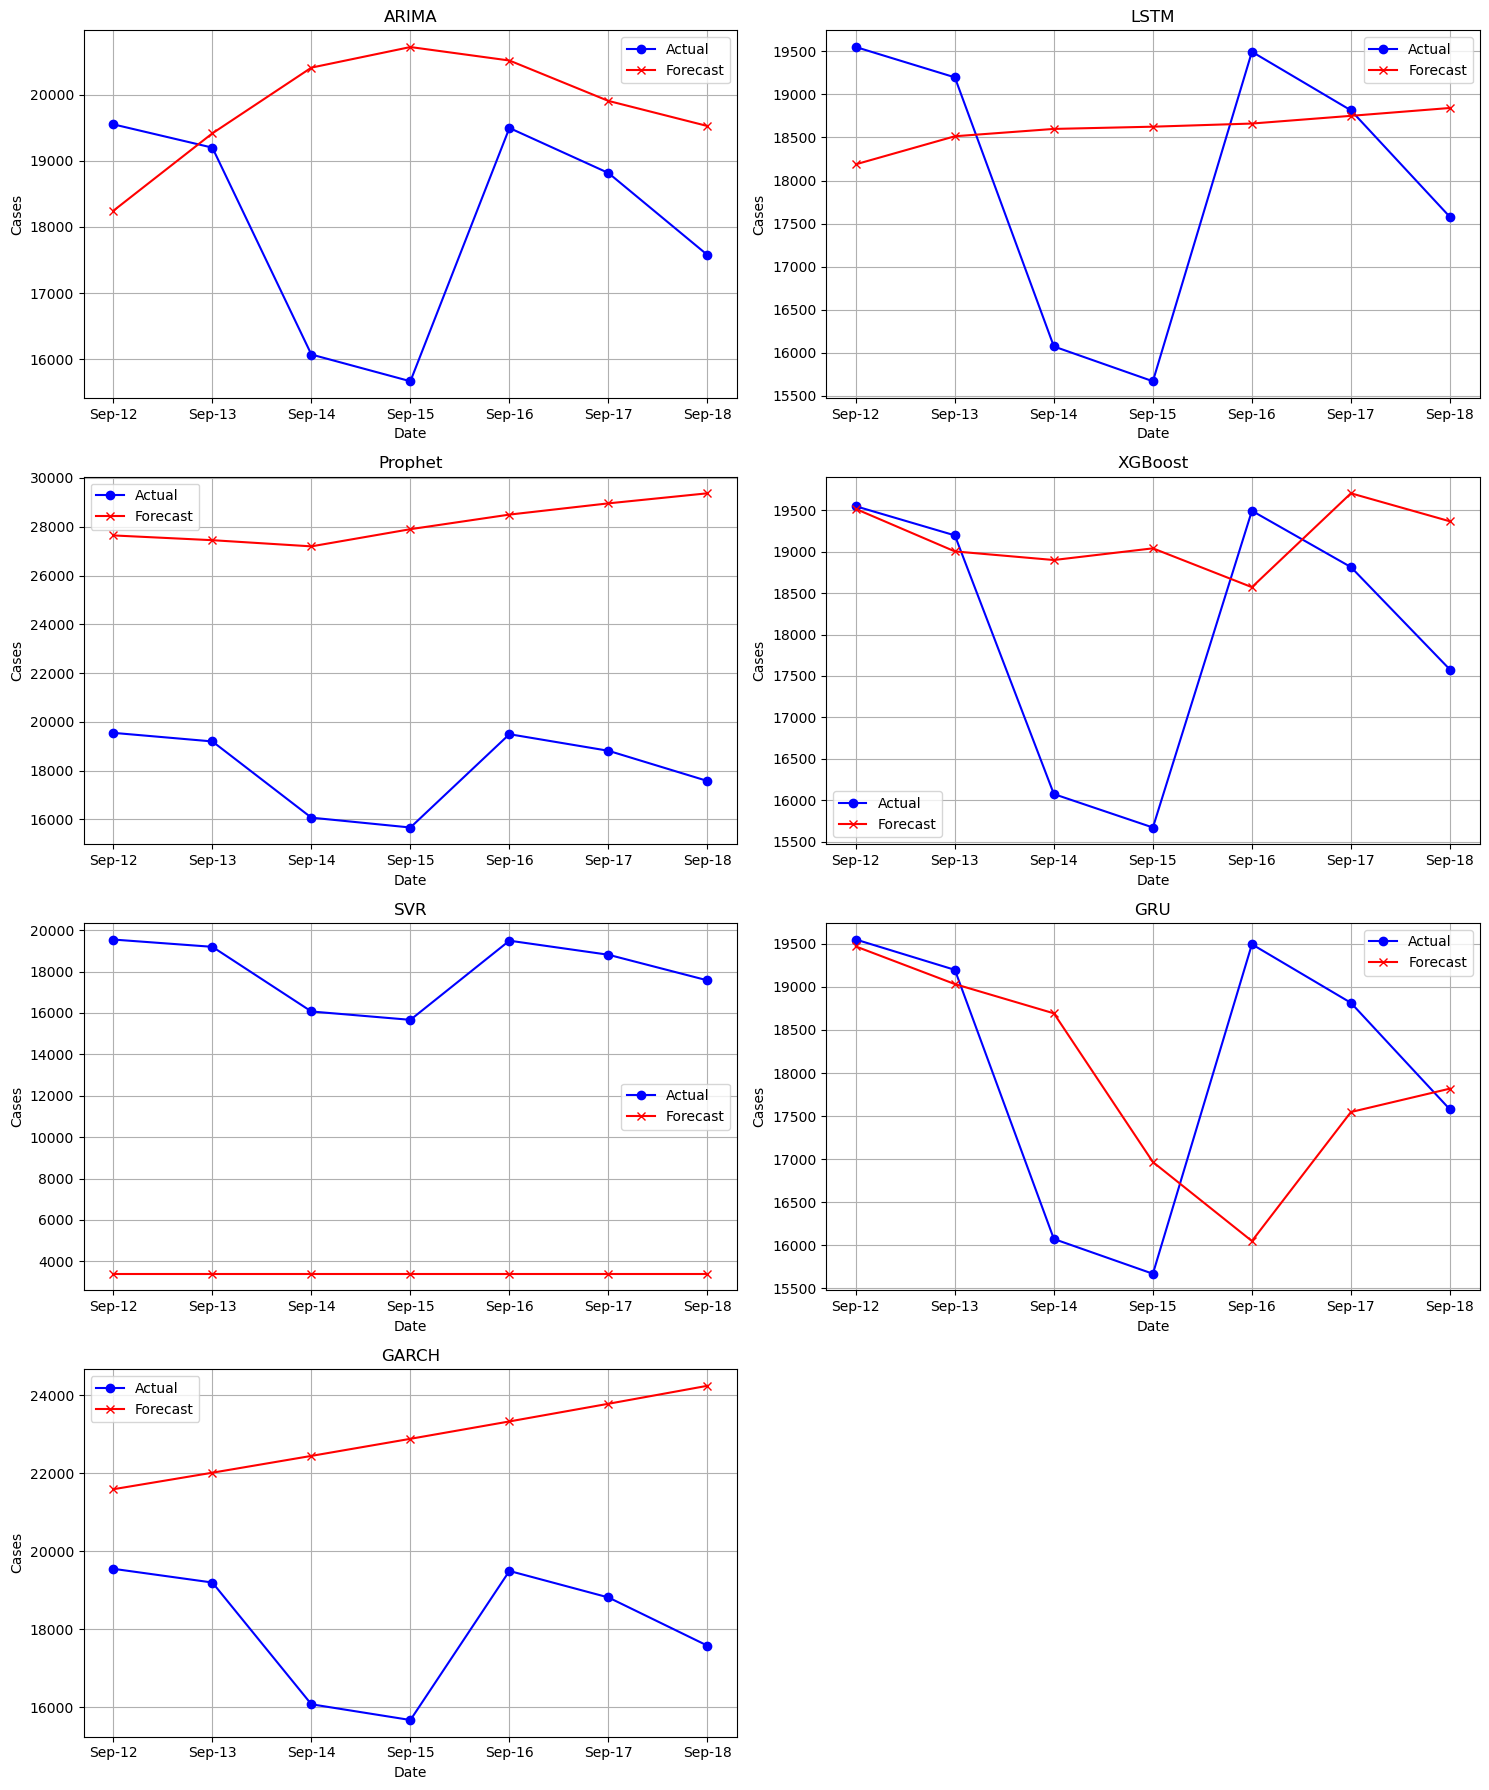

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Dates ===
dates = pd.to_datetime([
    "2021-09-12","2021-09-13","2021-09-14",
    "2021-09-15","2021-09-16","2021-09-17","2021-09-18"
])

# Prophet results
prophet_df = pd.DataFrame({
    "Date": dates,
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "Forecast": [27644.32,27448.95,27196.01,27900.53,28498.40,28959.57,29371.83]
})

# XGBoost results
xgb_df = pd.DataFrame({
    "Date": dates,
    "Actual": prophet_df["Actual"],
    "Forecast": [19517.19,19004.49,18900.46,19041.64,18572.49,19706.57,19368.04]
})

# SVR results
svr_df = pd.DataFrame({
    "Date": dates,
    "Actual": prophet_df["Actual"],
    "Forecast": [3396,3396,3396,3396,3396,3396,3396]
})

# GRU results
gru_df = pd.DataFrame({
    "Date": dates,
    "Actual": prophet_df["Actual"],
    "Forecast": [19469.72,19032.81,18693.05,16966.29,16049.02,17547.14,17818.82]
})

# GARCH results
garch_df = pd.DataFrame({
    "Date": dates,
    "Actual": prophet_df["Actual"],
    "Forecast": [21592.89,22016.94,22448.23,22886.86,23332.85,23786.45,24247.70]
})

# ARIMA results
arima_df = pd.DataFrame({
    "Date": dates,
    "Actual": prophet_df["Actual"],
    "Forecast": [18244.78,19414.10,20406.76,20717.74,20514.25,19903.91,19524.77]
})

# LSTM results
lstm_df = pd.DataFrame({
    "Date": dates,
    "Actual": prophet_df["Actual"],
    "Forecast": [18188.55,18514.04,18599.22,18625.16,18661.67,18751.13,18842.44]
})

# Dictionary of models
models = {
    "ARIMA": arima_df,
    "LSTM": lstm_df,
    "Prophet": prophet_df,
    "XGBoost": xgb_df,
    "SVR": svr_df,
    "GRU": gru_df,
    "GARCH": garch_df,
}

# === Plot all models ===
fig, axes = plt.subplots(4, 2, figsize=(15, 18))
axes = axes.flatten()

for i, (model_name, df) in enumerate(models.items()):
    ax = axes[i]
    ax.plot(df["Date"], df["Actual"], label="Actual", marker="o", color="blue")
    ax.plot(df["Date"], df["Forecast"], label="Forecast", marker="x", color="red")
    ax.set_title(model_name, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cases")
    ax.legend()
    ax.grid(True)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator())

# Remove empty subplot
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


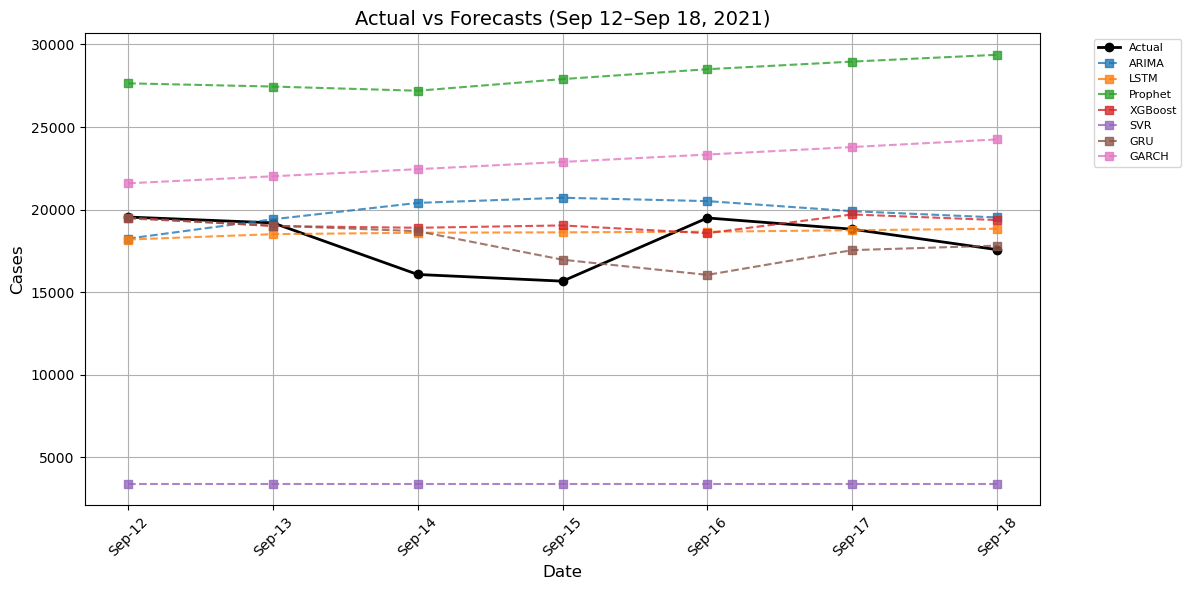

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# === DataFrame with all models together ===
df = pd.DataFrame({
    "Date": pd.to_datetime([
        "2021-09-12","2021-09-13","2021-09-14",
        "2021-09-15","2021-09-16","2021-09-17","2021-09-18"
    ]),
    "Actual": [19550,19198,16073,15669,19495,18815,17577],
    "ARIMA": [18244.78,19414.10,20406.76,20717.74,20514.25,19903.91,19524.77],
    "LSTM": [18188.55,18514.04,18599.22,18625.16,18661.67,18751.13,18842.44],
    "Prophet": [27644.32,27448.95,27196.01,27900.53,28498.40,28959.57,29371.83],
    "XGBoost": [19517.19,19004.49,18900.46,19041.64,18572.49,19706.57,19368.04],
    "SVR": [3396,3396,3396,3396,3396,3396,3396],
    "GRU": [19469.72,19032.81,18693.05,16966.29,16049.02,17547.14,17818.82],
    "GARCH": [21592.89,22016.94,22448.23,22886.86,23332.85,23786.45,24247.70],
    # replace with real hybrid values
})

# Add formatted date labels
df["DateLabel"] = df["Date"].dt.strftime("%b-%d")

# === Combined Plot (Actual vs all models) ===
plt.figure(figsize=(12, 6))

# Actual
plt.plot(df["DateLabel"], df["Actual"], marker="o", color="black", linewidth=2, label="Actual")

# Forecasts for all models
for model in df.columns[2:-1]:  # skip Date, Actual, DateLabel
    plt.plot(df["DateLabel"], df[model], marker="s", linestyle="--", label=model, alpha=0.8)

plt.title("Actual vs Forecasts (Sep 12–Sep 18, 2021)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
